<a href="https://colab.research.google.com/github/Templar137/AI_project/blob/main/%5BBaseline%5D_CNN2RNN(ResNet50%2C_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

baseline.ipynb <br>
.. ├ models <br>
.. └ data <br>
.... ├ train_sdf <br>
.... ├ dev_sdf <br>
.... ├ test_sdf <br>
.... ├ train_imgs <br>
.... ├ test_imgs <br>
.... ├ sample_train.csv <br>
.... ├ sample_test.csv <br>
.... └ sample_submission.csv <br>

In [2]:
!pip install kora -q
import kora.install.rdkit

from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## 사용 패키지

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from tqdm import tqdm
import os
import zipfile
import matplotlib.pyplot as plt

import torch
from torchsummary import summary as summary_
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader

In [ ]:
print('numpy verison :', np.__version__)
print('pandas version :', pd.__version__)
print('opencv version :', cv2.__version__)
print('rdkit version :', rdkit.__version__)
print('torch version :', torch.__version__)

numpy verison : 1.19.5
pandas version : 1.1.5
opencv version : 4.1.2
rdkit version : 2020.09.1
torch version : 1.9.0+cu102


## 데이터 로드

In [11]:
train = pd.read_csv('/content/gdrive/MyDrive/Dataset/Samsung_AI_Challenge/train.csv')
dev = pd.read_csv('/content/gdrive/MyDrive/Dataset/Samsung_AI_Challenge/dev.csv')

In [12]:
train.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724


In [13]:
dev.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,dev_0,O=C1c2ccccc2C2(c3ccccc31)c1ccccc1N(c1ccc(-c3nc...,2.7609,2.7540
1,dev_1,Cc1cccc2c3ccccc3n(-c3ccc(-c4c(-c5ccccc5)c(C#N)...,3.0495,3.0163
2,dev_2,CC1(C)c2ccccc2-c2ccc(-c3c(F)c(F)c(-c4ccc5c(c4)...,2.8314,2.1412
3,dev_3,CC(C)(C)c1ccc2c(c1)B1c3cc(C(C)(C)C)ccc3Oc3cc(-...,3.1813,2.9424
4,dev_4,O=C1c2cc(-c3ccc4c(c3)c3ccccc3n4-c3ccccc3)ccc2S...,2.9559,2.7362


In [52]:
train_org = pd.concat([train, dev])
train_90 = pd.concat([train, dev])
train_180 = pd.concat([train, dev])
train_270 = pd.concat([train, dev])

In [53]:
train_90['uid'] = train_90['uid'] + '_a'
train_180['uid'] = train_180['uid'] + '_b'
train_270['uid'] = train_270['uid'] + '_c'

In [54]:
train = pd.concat([train_org, train_90, train_180, train_270], ignore_index = True)

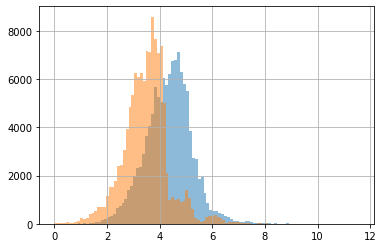

In [55]:
train['S1_energy(eV)'].hist(bins=100, alpha=0.5)
train['T1_energy(eV)'].hist(bins=100, alpha=0.5)
plt.show()

In [58]:
train

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724
...,...,...,...,...
121375,dev_66_c,N#Cc1cc(-c2ccc(N3c4ccccc4Oc4ccccc43)cc2)c(-c2c...,2.1939,2.1846
121376,dev_67_c,CC1(C)c2ccccc2N(c2ccc(-c3nc4ccc(N5c6ccccc6C(C)...,2.3537,2.3371
121377,dev_68_c,Cc1cc(-n2c3ccc(C(C)(C)C)cc3c3cc(C(C)(C)C)ccc32...,2.1364,2.1260
121378,dev_69_c,Cc1cc(-n2c3ccccc3c3ccccc32)cc(C)c1B1c2ccccc2B(...,2.2650,2.2511


## 데이터 전처리

분자의 구조적 특성을 찾기 위해 SMILES와 분자구조 이미지를 사용하였습니다.

In [ ]:
os.mkdir('/content/train_imgs')

In [17]:
name_train = sorted(os.listdir('/content/train_imgs'))

In [18]:
for name in tqdm(name_train):
    img = cv2.imread(f'/content/train_imgs/{name}', cv2.IMREAD_COLOR)
    img_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    plt.imsave('/content/train_imgs/' + name[:-4] + '_a.png', img_90)
    
    img_180 = cv2.rotate(img, cv2.ROTATE_180)
    plt.imsave('/content/train_imgs/' + name[:-4] + '_b.png', img_180)

    img_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    plt.imsave('/content/train_imgs/' + name[:-4] + '_c.png', img_270)

100%|██████████| 121380/121380 [1:14:02<00:00, 27.32it/s]


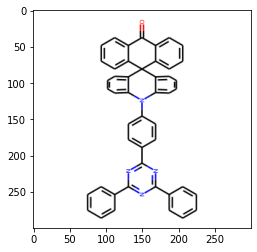

In [59]:
sample_img = cv2.imread('/content/train_imgs/dev_0_c.png')
plt.imshow(sample_img)
plt.show()

In [20]:
os.chdir('/content/train_imgs')

my_zip = zipfile.ZipFile('/content/gdrive/MyDrive/Dataset/Samsung_AI_Challenge/train__total_img.zip', 'w')

# 알집 만든거 풀기

In [ ]:
os.mkdir('/content/train_imgs')

## 하이퍼파라미터

In [48]:
device = torch.device("cuda:0")
BATCH_SIZE = 64
EPOCHS = 50
num_layers = 1
dropout_rate = 0.15
embedding_dim = 128
learning_rate = 1e-4
vision_pretrain = True
save_path = f'/content/gdrive/MyDrive/Samsung_model/best_model_dim{embedding_dim}_drop{dropout_rate}_layers{num_layers}_resnet101_augmentation.pt'

## SMILES Tokenizing

In [22]:
class SMILES_Tokenizer():
    def __init__(self, max_length):
        self.txt2idx = {}
        self.idx2txt = {}
        self.max_length = max_length
    
    def fit(self, SMILES_list):
        unique_char = set()
        for smiles in SMILES_list:
            for char in smiles:
                unique_char.add(char)
        unique_char = sorted(list(unique_char))
        for i, char in enumerate(unique_char):
            self.txt2idx[char]=i+2
            self.idx2txt[i+2]=char
            
    def txt2seq(self, texts):
        seqs = []
        for text in tqdm(texts):
            seq = [0]*self.max_length
            for i, t in enumerate(text):
                if i == self.max_length:
                    break
                try:
                    seq[i] = self.txt2idx[t]
                except:
                    seq[i] = 1
            seqs.append(seq)
        return np.array(seqs)

In [23]:
max_len = train.SMILES.str.len().max()
max_len

265

In [24]:
tokenizer = SMILES_Tokenizer(max_len)
tokenizer.fit(train.SMILES)

In [25]:
seqs = tokenizer.txt2seq(train.SMILES)
labels = train[['S1_energy(eV)', 'T1_energy(eV)']].to_numpy()
imgs = ('/content/train_imgs/'+train.uid+'.png').to_numpy()

100%|██████████| 30274/30274 [00:00<00:00, 83595.98it/s]


## 학습 데이터셋

In [36]:
from sklearn.utils import shuffle
imgs, seqs, labels = shuffle(imgs, seqs, labels, random_state=42)

In [50]:
train_imgs = imgs[:115000]
train_seqs = seqs[:115000]
train_labels = labels[:115000]
val_imgs = imgs[115000:]
val_seqs = seqs[115000:]
val_labels = labels[115000:]

In [51]:
train_imgs.shape, train_seqs.shape, train_labels.shape, val_imgs.shape, val_seqs.shape, val_labels.shape

((30274,), (30274, 265), (30274, 2), (0,), (0, 265), (0, 2))

In [39]:
pd.DataFrame(train_seqs)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264
0,22,22,4,22,5,22,4,30,29,34,24,12,32,5,22,4,19,27,5,26,4,22,22,10,26,22,11,22,22,22,22,22,11,26,10,5,22,22,10,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,22,22,4,22,5,26,22,33,10,37,33,33,33,10,22,22,22,22,26,22,10,22,22,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,22,22,22,26,10,26,22,4,22,22,5,22,4,22,4,19,27,5,27,5,19,22,10,22,33,10,33,33,33,4,7,33,11,33,33,33,33,33,11,29,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,22,33,10,33,33,33,33,11,33,4,19,27,5,36,4,22,22,22,4,19,27,5,26,22,12,22,22,22,22,26,22,12,19,27,5,33,36,33,10,11,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,27,19,22,10,22,30,22,20,20,24,32,4,22,4,19,27,5,27,5,26,4,33,11,36,33,33,4,22,4,23,5,4,23,5,23,5,33,33,11,22,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30269,27,33,10,33,4,7,33,11,33,33,33,37,11,5,33,33,33,33,10,7,33,10,36,33,11,33,33,33,33,33,11,40,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30270,22,22,10,19,22,4,22,4,19,27,5,26,33,11,33,33,33,33,33,11,23,5,22,4,33,11,33,33,33,33,33,11,22,4,23,5,4,23,5,23,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30271,22,35,33,10,33,33,33,33,4,8,22,19,26,8,26,33,11,33,36,33,12,33,33,33,33,33,12,36,11,5,33,10,22,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30272,22,30,22,20,24,32,10,22,22,30,22,20,20,32,4,22,26,5,4,26,22,4,19,27,5,27,22,33,11,33,33,33,33,33,11,5,22,10,4,22,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
class CustomDataset(Dataset):
    def __init__(self, imgs, seqs, labels=None, mode='train'):
        self.mode = mode
        self.imgs = imgs
        self.seqs = seqs
        if self.mode=='train':
            self.labels = labels
            
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        img = cv2.imread(self.imgs[i]).astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        if self.mode == 'train':
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'seq' : torch.tensor(self.seqs[i], dtype=torch.long),
                'label' : torch.tensor(self.labels[i], dtype=torch.float32)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'seq' : torch.tensor(self.seqs[i], dtype=torch.long),
            }

In [41]:
train_dataset = CustomDataset(train_imgs, train_seqs, train_labels)
val_dataset = CustomDataset(val_imgs, val_seqs, val_labels)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)

ValueError: ignored

In [ ]:
sample_batch = next(iter(train_dataloader))

In [ ]:
sample_batch['img'].size(), sample_batch['seq'].size(), sample_batch['label'].size()

In [ ]:
sample_batch['img'].dtype, sample_batch['seq'].dtype, sample_batch['label'].dtype

## 모델

ResNet50에 LSTM을 연결한 CNN2RNN 모델

In [7]:
class CNN_Encoder(nn.Module):
    def __init__(self, embedding_dim, rate):
        super(CNN_Encoder, self).__init__()
        model = models.resnet101(pretrained=vision_pretrain)
        modules = list(model.children())[:-2]
        self.feature_extract_model = nn.Sequential(*modules)
        self.dropout1 = nn.Dropout(rate)
        self.fc = nn.Linear(2048, embedding_dim)
        self.dropout2 = nn.Dropout(rate)
        
    def forward(self, x):
        x = self.feature_extract_model(x)
        x = x.permute(0,2,3,1)
        # x = x.reshape(1728, 10000)
        x = x.view(x.size(0), -1, x.size(3))
        x = self.dropout1(x)
        x = nn.ReLU()(self.fc(x))
        x = self.dropout2(x)
        return x

In [8]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_layers, rate):
        super(RNN_Decoder, self).__init__()
        self.embedding = nn.Embedding(max_len, embedding_dim)
        self.dropout = nn.Dropout(rate)
        self.lstm = nn.LSTM(embedding_dim, embedding_dim, num_layers)
        self.final_layer = nn.Linear((max_len+100)*embedding_dim, 2)

    def forward(self, enc_out, dec_inp):
        embedded = self.embedding(dec_inp)
        embedded = self.dropout(embedded)
        # embedded = embedded[None, ...]
        # enc_out = enc_out[None, ...]
        embedded = torch.cat([enc_out, embedded], dim = 1)
        hidden, _ = self.lstm(embedded)
        hidden = hidden.view(hidden.size(0), -1)
        output = nn.ReLU()(self.final_layer(hidden))
        return output

In [9]:
class CNN2RNN(nn.Module):
    def __init__(self, embedding_dim, max_len, num_layers, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_layers, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [26]:
model = CNN2RNN(embedding_dim=embedding_dim, max_len=max_len, num_layers=num_layers, rate=dropout_rate)
# model = model.to(device)

In [27]:
if torch.cuda.is_available():
    model.cuda()

## 학습 정의

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss()

In [ ]:
def train_step(batch_item, epoch, batch, training):
    img = batch_item['img'].to(device)
    seq = batch_item['seq'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, seq)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, seq).to(device)
            loss = criterion(output, label)
            
        return loss

# x = np.expand_dims(x, 1)      # if numpy array
# tensor = tensor.unsqueeze(1)  # if torch tensor

## 학습

In [ ]:
loss_plot, val_loss_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
3594it [27:53,  2.15it/s, Epoch=1, Loss=0.230873, Total Loss=0.344864]
200it [01:09,  2.86it/s, Epoch=1, Val Loss=0.276025, Total Val Loss=0.330244]
3594it [27:56,  2.14it/s, Epoch=2, Loss=0.219377, Total Loss=0.252827]
200it [01:09,  2.87it/s, Epoch=2, Val Loss=0.355551, Total Val Loss=0.274306]
3594it [27:55,  2.14it/s, Epoch=3, Loss=0.251320, Total Loss=0.222462]
200it [01:09,  2.89it/s, Epoch=3, Val Loss=0.399167, Total Val Loss=0.242183]
3594it [27:54,  2.15it/s, Epoch=4, Loss=0.148482, Total Loss=0.203898]
200it [01:09,  2.88it/s, Epoch=4, Val Loss=0.147223, Total V

## 학습 결과

In [3]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.legend()
plt.show()

NameError: ignored

## 모델 복원

In [28]:
model = torch.load(save_path)

## 테스트 데이터 및 제출 양식 로드

In [29]:
test = pd.read_csv('/content/gdrive/MyDrive/Dataset/Samsung_AI_Challenge/test.csv')
submission = pd.read_csv('/content/gdrive/MyDrive/Dataset/Samsung_AI_Challenge/sample_submission.csv')

## 테스트 데이터 전처리

In [31]:
os.mkdir('/content/test_imgs')

In [32]:
for idx, row in tqdm(test.iterrows()):
    file = row['uid']
    smiles = row['SMILES']
    m = Chem.MolFromSmiles(smiles)
    if m != None:
        img = Draw.MolToImage(m, size=(300,300))
        img.save(f'/content/test_imgs/{file}.png')

602it [00:08, 74.18it/s]


## 테스트 데이터셋

In [33]:
test_seqs = tokenizer.txt2seq(test.SMILES)
test_imgs = ('/content/test_imgs/'+test.uid+'.png').to_numpy()

100%|██████████| 602/602 [00:00<00:00, 70904.24it/s]


In [42]:
test_dataset = CustomDataset(imgs=test_imgs, seqs=test_seqs, labels=None, mode='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2)

## 추론 및 제출

In [43]:
def predict(dataset):
    model.eval()
    result = []
    for batch_item in dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['seq'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = output.cpu().numpy()
        gap = output[:, 0] - output[:, 1]
        gap = np.where(gap<0, 0, gap)
        result.extend(list(gap))
        
    return result

In [44]:
pred = predict(test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [45]:
submission['ST1_GAP(eV)'] = pred

In [ ]:
submission

,uid,ST1_GAP(eV)
0,test_0,0.976529
1,test_1,2.122211
2,test_2,0.988469
3,test_3,0.706192
4,test_4,1.113781
...,...,...
597,test_597,0.302718
598,test_598,0.125923
599,test_599,0.211123
600,test_600,0.738367


In [46]:
submission.to_csv('/content/dacon_baseline_resnet101_embeddingdim_128_augmentation.csv', index=False)

제출 API 사용법 => https://dacon.io/forum/403557

In [ ]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
    'dacon_baseline.csv', 
    '개인 Token', 
    '235789', 
    'DACONIO', 
    'DACON_Baseline'
)

{'isSubmitted': True, 'detail': 'Success'}


# Public LB Score : 0.1871130054